## Model

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


class MalariaClassifier:
    def __init__(self, input_size, c):
        self.input_size = input_size
        self.path_model = "./model"
        self.c = c
        self.model = self._build_model(input_size, c)
        self.train_generator = None
        self.validation_generator = None

    def _build_model(self, input_size, c):
        model = Sequential([
            InputLayer(input_shape=input_size + (c,)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid'),
        ])

        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.binary_crossentropy,
            metrics=['accuracy'],
        )

        return model

    def image_data_generator(self, dataset):
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            fill_mode="nearest",
            rotation_range=20,
            horizontal_flip=True,
            vertical_flip=True,
        )

        self.train_generator = datagen.flow_from_directory(
            os.path.join(dataset, "training"),
            target_size=self.input_size,
            batch_size=32,
            shuffle=True,
            class_mode="binary",
            color_mode="rgb",
        )

        self.validation_generator = datagen.flow_from_directory(
            os.path.join(dataset, "validation"),
            target_size=self.input_size,
            batch_size=32,
            shuffle=True,
            class_mode="binary",
            color_mode="rgb",
        )

    def train(self, epochs):
        if not os.path.exists(self.path_model):
            os.makedirs(self.path_model)

        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filepath = f"{self.path_model}/{current_time}.h5"
        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            steps_per_epoch=len(self.train_generator),
            epochs=epochs,
            callbacks=[
                ModelCheckpoint(
                    filepath=filepath,
                    monitor="accuracy",
                    save_best_only=True,
                ),
            ],
        )

        self.model.save(f"{self.path_model}/malaria_model.h5")

        return history

    def summary(self):
        self.model.summary()

    def set_save_path(self, path):
        self.path_model = path

    def show_images(self):
        for images, labels in self.train_generator:
            for i in range(len(images)):
                plt.imshow(images[i].squeeze(), cmap='gray')
                plt.title(f'Label: {labels[i]}')
                plt.show()
            break

## Train model



Found 22047 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                   

c:\Users\sayam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 46s 66ms/step - loss: 0.1936 - accuracy: 0.9384 - val_loss: 0.1685 - val_accuracy: 0.9465
Epoch 3/100
689/689 [==============================] - 45s 65ms/step - loss: 0.1619 - accuracy: 0.9517 - val_loss: 0.1653 - val_accuracy: 0.9499
Epoch 4/100
689/689 [==============================] - 45s 65ms/step - loss: 0.1571 - accuracy: 0.9526 - val_loss: 0.2110 - val_accuracy: 0.9465
Epoch 5/100
689/689 [==============================] - 45s 65ms/step - loss: 0.1537 - accuracy: 0.9546 - val_loss: 0.1619 - val_accuracy: 0.9516
Epoch 6/100
689/689 [==============================] - 45s 66ms/step - loss: 0.1540 - accuracy: 0.9555 - val_loss: 0.1638 - val_accuracy: 0.9508
Epoch 7/100
689/689 [==============================] - 46s 66ms/step - loss: 0.1476 - accuracy: 0.9560 - val_loss: 0.1633 - val_accuracy: 0.9454
Epoch 8/100
689/689 [==============================] - 45s 66ms/step - loss: 0.1420 - accuracy: 0.9577 - val_loss: 0.1578 - val_accuracy: 0.95

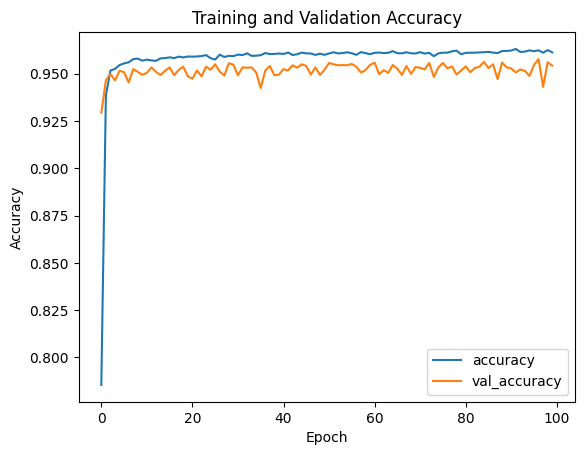

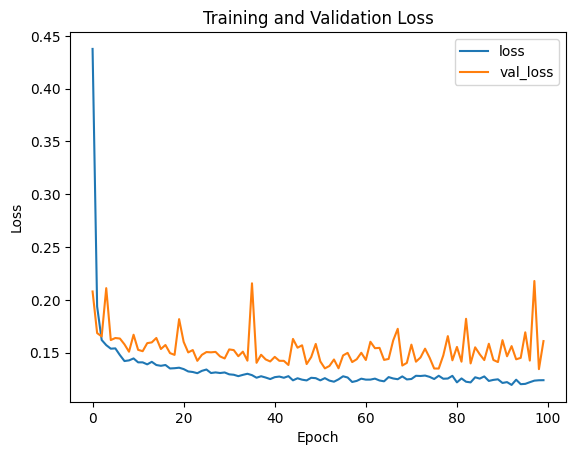

In [2]:
import matplotlib.pyplot as plt


def main() :

    model = MalariaClassifier((50, 50), 3)
    model.image_data_generator("./database")
    # model.show_images()
    model.summary()
    history = model.train(100)
    return history


def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()


if __name__ == "__main__":
    history = main()
    plot_accuracy(history)
    plot_loss(history)

## prediction

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the model
model = tf.keras.models.load_model('./model/malaria_model.h5')

img_path = "./database/validation/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png"
img = image.load_img(img_path, target_size=(50, 50))  # Assuming your model expects input size 224x224
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = tf.keras.applications.resnet.preprocess_input(img_array) 

# Predict
prediction = model.predict(img_array)
print(prediction)


1/1 [==============================] - 0s 103ms/step
[[1.]]
